### Import Packages

In [1]:
import ray
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from mpl_toolkits.mplot3d import Axes3D
from concurrent.futures import ThreadPoolExecutor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score

from utils.system import *
from class_data.data import Data

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

### Data

In [2]:
# Get SP500 candidates and set keys to the given year
def get_candidate():
    with open(get_data() / 'sp500_candidates.pkl', 'rb') as f:
        candidates = pickle.load(f)
    beginning_year = [date for date in candidates.keys() if date.month == 1]
    candidates = {date.year: candidates[date] for date in beginning_year if date in candidates}
    return candidates

# Get unique sp500 tickers
sp500_all = get_candidate()
sp500 = set()
for year, tickers in sp500_all.items():
    if year < 2000:
        continue
    sp500.update(tickers)
sp500 = list(sp500)

In [3]:
# Load openai embeddings
cc_emb = Data(folder_path=get_format_data() / 'openai', file_pattern='cc_emb_textemb3small_all_*')
cc_emb = cc_emb.concat_files()
cc_emb.shape

Loading Data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1198/1198 [00:13<00:00, 86.28it/s]


(1197859, 1)

In [4]:
# Load cc articles
cc_art = Data(folder_path=get_format_data() / 'art', file_pattern='cc_art_all_*')
cc_art = cc_art.concat_files()
cc_art.shape

Loading Data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.36it/s]


(1197859, 11)

In [5]:
# Remove NAN values
index = cc_emb.reset_index()
index_null = index.loc[index.ada_embedding.isnull()].index.tolist()
cc_art = cc_art.reset_index()
cc_art = cc_art.loc[~cc_art.index.isin(index_null)]
cc_art = cc_art.set_index(['fid', 'date'])
cc_emb = cc_emb.dropna()
print(cc_emb.shape)
print(cc_art.shape)

(1197847, 1)
(1197847, 11)


In [6]:
# Firm-Level Risk
all_risk = pd.read_csv(get_data() / 'firmquarter_2022q1.csv', delimiter='\t', engine='python')
all_risk = all_risk.set_index(['gvkey', 'date'])
print(all_risk.columns.tolist())

['PRisk', 'NPRisk', 'Risk', 'PSentiment', 'NPSentiment', 'Sentiment', 'PRiskT_economic', 'PRiskT_environment', 'PRiskT_trade', 'PRiskT_institutions', 'PRiskT_health', 'PRiskT_security', 'PRiskT_tax', 'PRiskT_technology', 'company_name', 'hqcountrycode', 'isin', 'cusip', 'ticker', 'date_earningscall', 'Covid_Exposure', 'Covid_Neg_Sentiment', 'Covid_Pos_Sentiment', 'Covid_Net_Sentiment', 'Covid_Risk', 'SARS_Exposure', 'H1N1_Exposure', 'Zika_Exposure', 'Ebola_Exposure', 'Brexit_Exposure', 'Brexit_Neg_Sentiment', 'Brexit_Pos_Sentiment', 'Brexit_Net_Sentiment', 'Brexit_Risk']


In [7]:
# Link Data
link = pd.read_parquet(r'C:\Jonathan\QuantResearch\AlgoTradingModels\algofacto\trade_live\data_parquet\data_link.parquet.brotli')
link = link.loc[link.ticker.isin(sp500)]
link = link.drop_duplicates(subset='gvkey', keep='last')
link['gvkey'] = link['gvkey'].astype('int64')
sp500_gvkey = link['gvkey'].unique().tolist()
ticker_to_gvkey_mapping = link.set_index('ticker')['gvkey'].to_dict()
gvkey_to_ticker_mapping = link.set_index('gvkey')['ticker'].to_dict()

### Query

In [8]:
# Set index to (ticker, date)
cc_emb['ticker'] = cc_art['companyTicker']
cc_emb = cc_emb.reset_index().set_index(['ticker', 'date'])
del cc_emb['fid']

In [9]:
# Calculate aggregrated embedding per (ticker, date)
agg_emb = cc_emb.groupby(['ticker', 'date'])[['ada_embedding']].mean()

In [10]:
# Function to convert 'YYYY-MM-DD' to 'YYYYqQ'
def date_to_quarter(date):
    year = date.year  
    quarter = (date.month - 1) // 3 + 1 
    return f'{year}q{quarter}'

new_index = pd.MultiIndex.from_tuples([(x[0], date_to_quarter(x[1])) for x in agg_emb.index])
agg_emb.index = new_index
agg_emb.index.names = ['ticker', 'date']

In [11]:
# Calculate aggregrated score per quarter
agg_emb = agg_emb.groupby(['ticker', 'date'])[['ada_embedding']].mean()

### GVKEY join with PRisk

In [12]:
# Param
risk = 'PRisk'

In [13]:
# Set risk
compare_risk = all_risk[[risk]]

In [14]:
# Map ticker to gvkey
agg_emb['gvkey'] = agg_emb.index.get_level_values('ticker').map(ticker_to_gvkey_mapping)
print(f"Unique Tickers: {len(agg_emb.index.get_level_values('ticker').unique())}")
agg_emb = agg_emb.dropna(subset='gvkey')
print(f"Unique Tickers with gvkey: {len(agg_emb.index.get_level_values('ticker').unique())}")
agg_emb['gvkey'] = agg_emb['gvkey'].astype('int64')
agg_emb = agg_emb.reset_index().set_index(['gvkey', 'date'])

Unique Tickers: 655
Unique Tickers with gvkey: 642


<Axes: >

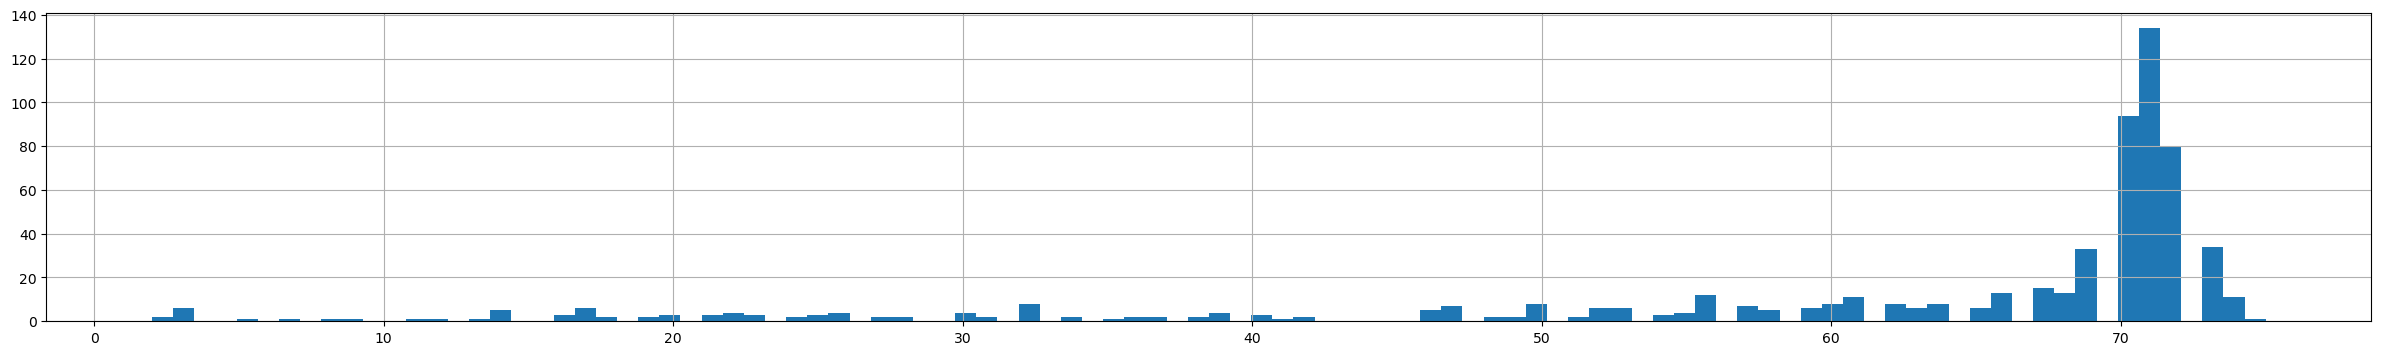

In [15]:
# Number of CC per GVKEY
counts_per_gvkey = agg_emb.groupby('gvkey').size()
counts_per_gvkey.hist(bins=100, figsize=(30, 4))

In [16]:
# Join
compare = agg_emb.join(compare_risk)
compare = compare.reset_index().set_index(['gvkey', 'ticker', 'date'])
compare = compare.dropna()

In [17]:
# Filter out tickers with less than 20 CC
compare = compare.groupby('gvkey').filter(lambda x: len(x) >=20)
print(f"Unique Tickers with more than 20 CC for score and firm-level risk: {len(compare.index.get_level_values('gvkey').unique())}")

Unique Tickers with more than 20 CC for score and firm-level risk: 593


In [18]:
# Create regression dataframe
emb_df = pd.DataFrame(compare['ada_embedding'].tolist(), index=compare.index)
emb_df.columns = [f'emb_{i+1}' for i in range(emb_df.shape[1])]
regress = pd.concat([emb_df, compare['PRisk']], axis=1)

### Regression

In [19]:
# Create data
X = regress.iloc[:, :1536]
y = regress.iloc[:, 1536] 

In [20]:
# Gridsearch
alpha_grid = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1] + [0.5 * i for i in range(1, int(30 / 0.5) + 2)]

In [21]:
# Display data
regress.head(5)

emb_1   emb_2  emb_3  emb_4  emb_5  emb_6   emb_7  \
gvkey  ticker date                                                        
126554 A      2002q2 0.0197 -0.0066 0.0360 0.0075 0.0186 0.0263 -0.0256   
              2002q3 0.0416 -0.0002 0.0335 0.0079 0.0090 0.0281 -0.0192   
              2002q4 0.0304  0.0121 0.0419 0.0069 0.0082 0.0261 -0.0154   
              2003q1 0.0259  0.0207 0.0303 0.0017 0.0236 0.0282 -0.0114   
              2003q2 0.0153  0.0138 0.0405 0.0039 0.0167 0.0171 -0.0156   

                      emb_8  emb_9  emb_10  ...  emb_1528  emb_1529  emb_1530  \
gvkey  ticker date                          ...                                 
126554 A      2002q2 0.0429 0.0160 -0.0154  ...    0.0220    0.0014    0.0028   
              2002q3 0.0445 0.0202 -0.0079  ...    0.0259   -0.0056    0.0062   
              2002q4 0.0419 0.0183 -0.0141  ...    0.0203   -0.0063    0.0068   
              2003q1 0.0400 0.0243 -0.0168  ...    0.0259   -0.0005    0.0004   
              2003q2 0.0334 0.0156 -0.0207  ...    0.0213    0.0007    0.0024   

                      emb_1531  emb_1532  emb_1533  emb_1534  emb_1535  \
gvkey  ticker date                                                       
126554 A      2002q2   -0.0019    0.0313    0.0097   -0.0095    0.0115   
              2002q3   -0.0027    0.0323    0.0140   -0.0061    0.0126   
              2002q4   -0.0031    0.0253    0.0097   -0.0075    0.0147   
              2003q1   -0.0033    0.0223    0.0115   -0.0056    0.0067   
              2003q2   -0.0038    0.0295    0.0056   -0.0123    0.0011   

                      emb_1536    PRisk  
gvkey  ticker date                       
126554 A      2002q2   -0.0009  40.4431  
              2002q3    0.0056  38.6446  
              2002q4   -0.0001  39.8233  
              2003q1    0.0006  74.9287  
              2003q2    0.0081 114.2990  

[5 rows x 1537 columns]

### Ridge

In [41]:
# Ridge Cross-Validation
def ridge_cv(alpha, X, y):
    ridge_model = Ridge(alpha=alpha)
    scores = cross_val_score(ridge_model, X, y, cv=5, scoring='r2')
    return (alpha, scores.mean())

# Ridge Cross-Validation Parallelized
def run_parallel_ridge_cv(alpha_grid, X, y, batch_size=10):
    results = []
    with ThreadPoolExecutor() as executor:
        for i in range(0, len(alpha_grid), batch_size):
            batch_alphas = alpha_grid[i:i+batch_size]
            batch_results = list(tqdm(executor.map(lambda alpha: ridge_cv(alpha, X, y), batch_alphas), total=len(batch_alphas), desc=f'Processing batch {i // batch_size + 1}'))
            results.extend(batch_results)
    
    results_df = pd.DataFrame(results, columns=['alpha', 'mean_r2'])
    results_df = results_df.set_index('alpha')
    results_df = results_df.sort_index()
    return results_df

In [42]:
# Ridge CV
results_ridge = run_parallel_ridge_cv(alpha_grid, X, y)

Processing batch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:17<00:00,  2.45s/it]


<Axes: xlabel='alpha'>

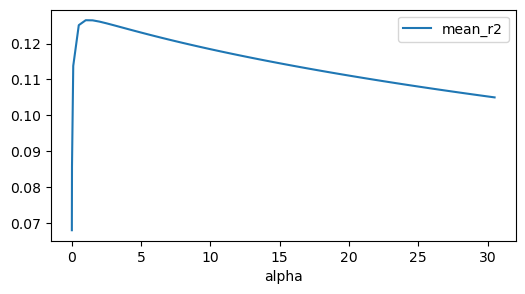

In [43]:
# Plot results 
results_ridge.plot(figsize=(6,3))

In [49]:
# Max results
display(results_ridge.loc[results_ridge.mean_r2 == results_ridge.mean_r2.max()])

,mean_r2
alpha,
1.0000,0.1265


### Lasso

In [22]:
# Lasso Cross-Validation
def lasso_cv(alpha, X, y):
    lasso_model = Lasso(alpha=alpha)
    scores = cross_val_score(lasso_model, X, y, cv=5, scoring='r2')
    return (alpha, scores.mean())

# Lasso Cross-Validation Parallelized
def run_parallel_lasso_cv(alpha_grid, X, y, batch_size=1):
    results = []
    with ThreadPoolExecutor() as executor:
        for i in range(0, len(alpha_grid), batch_size):
            batch_alphas = alpha_grid[i:i+batch_size]
            batch_results = list(tqdm(executor.map(lambda alpha: lasso_cv(alpha, X, y), batch_alphas), total=len(batch_alphas), desc=f'Processing batch {i // batch_size + 1}'))
            results.extend(batch_results)
    
    results_df = pd.DataFrame(results, columns=['alpha', 'mean_r2'])
    results_df = results_df.set_index('alpha')
    results_df = results_df.sort_index()
    return results_df

In [ ]:
# Lasso CV
results_lasso = run_parallel_lasso_cv(alpha_grid, X, y)

Processing batch 1:   0%|                                                                                                                                                                   | 0/1 [00:00<?, ?it/s]

In [ ]:
# Plot results 
results_lasso.plot(figsize=(6,3))

In [ ]:
# Max results
display(results_lasso.loc[results_lasso.mean_r2 == results_lasso.mean_r2.max()])

### ElasticNet

In [53]:
# Gridsearch
alpha_grid = [0.01, 0.1, 1, 10, 100]
l1_ratio_grid = [0.1, 0.5, 0.7, 0.9, 0.95, 1]

In [58]:
# ElasticNet Cross-Validation
def elasticnet_cv(params, X, y):
    alpha, l1_ratio = params
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    return (alpha, l1_ratio, scores.mean())

# ElasticNet Cross-Validation Parallelized
def run_parallel_elasticnet_cv(alpha_grid, l1_ratio_grid, X, y, batch_size=10):
    param_grid = [(alpha, l1_ratio) for alpha in alpha_grid for l1_ratio in l1_ratio_grid]
    results = []
    with ThreadPoolExecutor() as executor:
        for i in range(0, len(param_grid), batch_size):
            batch_params = param_grid[i:i+batch_size]
            batch_results = list(tqdm(executor.map(lambda params: elasticnet_cv(params, X, y), batch_params), total=len(batch_params), desc=f'Processing batch {i // batch_size + 1}'))
            results.extend(batch_results)
    
    results_df = pd.DataFrame(results, columns=['alpha', 'l1_ratio', 'mean_r2'])
    results_df = results_df.sort_values(by='mean_r2', ascending=False)
    return results_df

In [59]:
# Ridge CV
results_elasticnet = run_parallel_elasticnet_cv(alpha_grid, l1_ratio_grid, X, y)

Processing batch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.32s/it]


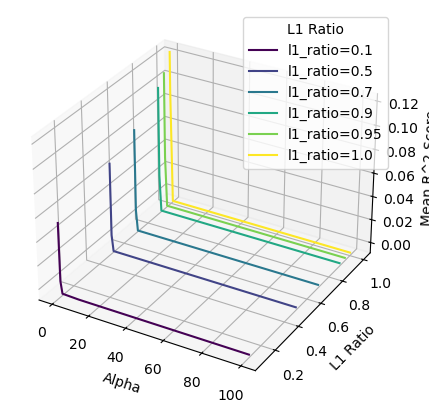

In [80]:
# Plot results 
results_elasticnet = results_elasticnet.sort_values(by=['l1_ratio', 'alpha'])
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')
l1_ratios = results_elasticnet['l1_ratio'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(l1_ratios)))
for l1_ratio, color in zip(l1_ratios, colors):
    subset = results_elasticnet[results_elasticnet['l1_ratio'] == l1_ratio]
    ax.plot(subset['alpha'], subset['l1_ratio'], subset['mean_r2'], label=f'l1_ratio={l1_ratio}', color=color)
ax.set_xlabel('Alpha')
ax.set_ylabel('L1 Ratio')
ax.set_zlabel('Mean R^2 Score')
ax.legend(title='L1 Ratio')
plt.show()

In [68]:
# Max results
display(results_elasticnet.loc[results_elasticnet.mean_r2 == results.mean_r2.max()])

,l1_ratio,alpha,mean_r2
26,1.0000,0.0100,0.1232


### Lightgbm

In [82]:
# LightGBM regression cross-validation
def lightgbm_cv(params, X, y):
    num_leaves, learning_rate = params
    model = LGBMRegressor(num_leaves=num_leaves, learning_rate=learning_rate)
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    return (num_leaves, learning_rate, scores.mean())

In [83]:
# (Num leaves, Learning Rate)
params_grid = [(31, 0.1), (31, 0.01), (50, 0.1), (50, 0.01)]

In [85]:
# Train
results = [lightgbm_cv(params, X, y) for params in tqdm(params_grid)]
results_gbm = pd.DataFrame(results, columns=['num_leaves', 'learning_rate', 'mean_r2'])

  0%|                                                                                                                                                                                       | 0/4 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391680
[LightGBM] [Info] Number of data points in the train set: 29973, number of used features: 1536
[LightGBM] [Info] Start training from score 121.310236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.237514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391680
[LightGBM] [Info] Number of data points in the train set: 29973, number of used features: 1536
[LightGBM] [Info] Start training from score 123.159102
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391680
[LightGBM] [Info] Number of data points in the train set: 29974, number of used features: 1536
[LightGBM] 

 25%|███████████████████████████████████████████▊                                                                                                                                   | 1/4 [00:40<02:02, 40.82s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.234332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391680
[LightGBM] [Info] Number of data points in the train set: 29973, number of used features: 1536
[LightGBM] [Info] Start training from score 121.310236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391680
[LightGBM] [Info] Number of data points in the train set: 29973, number of used features: 1536
[LightGBM] [Info] Start training from score 123.159102
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391680
[LightGBM] [Info] Number of data points in the train set: 29974, number of used features: 1536
[LightGBM] 

 50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 2/4 [01:29<01:30, 45.40s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.331238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391680
[LightGBM] [Info] Number of data points in the train set: 29973, number of used features: 1536
[LightGBM] [Info] Start training from score 121.310236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.244645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391680
[LightGBM] [Info] Number of data points in the train set: 29973, number of used features: 1536
[LightGBM] [Info] Start training from score 123.159102
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.250675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391680
[LightGBM] [Info] Number of data points in the train set: 29974, number of used features: 1536
[LightGBM] 

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 3/4 [02:30<00:52, 52.45s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391680
[LightGBM] [Info] Number of data points in the train set: 29973, number of used features: 1536
[LightGBM] [Info] Start training from score 121.310236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.251456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391680
[LightGBM] [Info] Number of data points in the train set: 29973, number of used features: 1536
[LightGBM] [Info] Start training from score 123.159102
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.306284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391680
[LightGBM] [Info] Number of data points in the train set: 29974, number of used features: 1536
[LightGBM] 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:36<00:00, 54.05s/it]


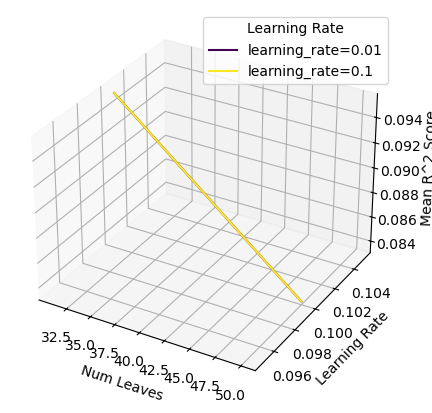

In [91]:
# Plot results 
results_gbm = results_gbm.sort_values(by=['num_leaves', 'learning_rate'])
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')
learning_rates = results_gbm['learning_rate'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(l1_ratios)))
for learning_rate, color in zip(learning_rates, colors):
    subset = results_gbm[results_gbm['learning_rate'] == l1_ratio]
    ax.plot(subset['num_leaves'], subset['learning_rate'], subset['mean_r2'], label=f'learning_rate={learning_rate}', color=color)
ax.set_xlabel('Num Leaves')
ax.set_ylabel('Learning Rate')
ax.set_zlabel('Mean R^2 Score')
ax.legend(title='Learning Rate')
plt.show()